*A solution to philosophers2 based on the solution provided in the original paper (EWD310).*

The life of a philosopher consists of an alternation of thinking and eating.

Five philosophers, numbered from 0 through 4 are living in a house where the table laid for them, each philosopher having his own place at the table:

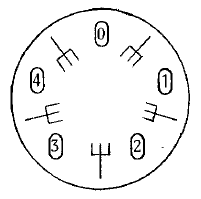

Their only problem - besides those of philosophy - is that the dish served is a very difficult kind of spaghetti, that has to be eaten with two forks. There are two forks next to each plate, so that presents no difficulty: as a consequence, however, no two neighbours may be eating simultaneously.

**The philosophers overcome this problem by signalling amongst themselves whether or not it is appropriate to eat. When a philosopher lets the others know that he is hungry, he checks to make sure that none of his neighbours are eating before picking up his forks and consuming his meal. Once he is finished, he signals to his immediate neighbours that he is no longer eating. The philosophers next to him can then follow the same procedure should they get hungry. Thus, the philosophers ensure that no two neighbours attempt to eat their meal simultaneously.**

### User Stories

* As a PHILOSOPHER I want to...
    * think *so I can ask questions and get answers*
    * eat *so I can continue thinking*
    * have acceess to two forks so I can eat

Text in italic is inferred.

### Assumptions

* At any given moment, a philosopher is either thinking or eating. If the philosopher is not eating, it can be assumed that he is thinking and vice-versa.

### Design Decisions

* Philosophers think by default.
* Philosophers think until they start eating and eat until they start thinking.
* Forks are modelled as classes so they can be passed by reference to each philosopher.

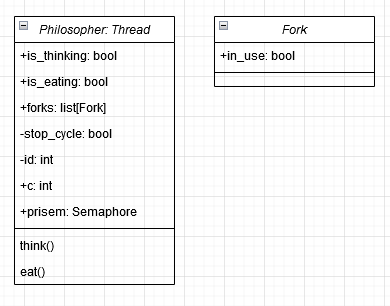

In [148]:
# This file is a part of the final year project "Story and Software" (CSC4006).
# Author: Konrad Mosoczy (Queen's University Belfast - QUB)
# https://github.com/konmos/csc4006 (also available on GitLab)
# ------------------------------------------------------------------------------
# This is the DP notebook implementation 3.

import time
import random
import threading
from queue import Queue
from enum import Enum, auto

In [149]:
# For visualisation
EVENTS = Queue()  

class PhilosopherEvent(Enum):
    THINKING = auto()
    EATING = auto()
    HUNGRY = auto()

In [150]:
class ForkInUse(Exception):
    """Raised when an attempt is made to eat with a fork which is already used."""

In [151]:
class Fork:
    """A single fork."""
    def __init__(self):
        self.in_use = False
    
    def __repr__(self):
        return f'<Fork [in_use={self.in_use}]>'

In [152]:
class Philosopher(threading.Thread):
    '''
    Threaded implementation of the Dining Philosopher's Problem.
    There is no possibility of deadlock in this implementation.
    Solution based on EWD310.
    '''
    mutex = threading.Semaphore(1)  # Global semaphore
    table = []  # All philosophers including myself
    
    def __init__(self, forks, *a, **kw):
        super().__init__(*a, **kw)
        
        self.is_thinking = True
        self.is_eating = False
        self.forks = forks
        
        self._stop_cycle = False  # For controlling thread interrupts
        
        self.c = 0  # state; 0 = thinking, 1 = hungry, 2 = eating
        self.prisem = threading.Semaphore(0)  # private semaphore
        
        self._id = len(Philosopher.table)  # ID is equal to position in table
        Philosopher.table.append(self)
    
    def think(self):
        self.forks[0].in_use = False
        self.forks[1].in_use = False
        
        self.is_thinking = True
        self.is_eating = False
    
    def eat(self):
        if self.forks[0].in_use or self.forks[1].in_use:
            raise ForkInUse
        
        self.forks[0].in_use = True
        self.forks[1].in_use = True
        
        self.is_eating = True
        self.is_thinking = False
    
    def join(self, *args, **kwargs):
        self._stop_cycle = True
        super().join(*args, **kwargs)
    
    def run(self):
        """
        Thread activity representing the Philosopher's
        alternating cycle of eating and thinking.
        """
#         cycle_duration = random.randrange(2, 10)
        cycle_duration = 2
        
        # test procedure as described in the paper
        def test(k):
            c = Philosopher.table

            if c[(k-1) % len(c)].c != 2 and c[k].c == 1 and c[(k+1) % len(c)].c != 2:
                c[k].c = 2
                c[k].prisem.release()
        
        # At this stage, the philosopher is thinking by default.
        
        while not self._stop_cycle:
            print(f'{self} is thinking\n')
            EVENTS.put((self._id, PhilosopherEvent.THINKING))
            
            Philosopher.mutex.acquire()
            
            self.c = 1
            EVENTS.put((self._id, PhilosopherEvent.HUNGRY))
            
            test(self._id)
            
            Philosopher.mutex.release()
            self.prisem.acquire()

            self.eat()
            
            EVENTS.put((self._id, PhilosopherEvent.EATING))
            print(f'{self} is now eating\n')
            time.sleep(cycle_duration)
            
            Philosopher.mutex.acquire()
            
            self.think()
            self.c = 0
            
            test((self._id + 1) % len(Philosopher.table))
            test((self._id - 1) % len(Philosopher.table))
            
            Philosopher.mutex.release()
    
    def __repr__(self):
        return f'<Philosopher [{self._id}] [eating={self.is_eating} thinking={self.is_thinking}]>'

In [153]:
if __name__ == '__main__':
    n_philosophers = 5

    forks = [Fork() for _ in range(n_philosophers)]  # as many forks as philosophers

    philosophers = [
        Philosopher(
            (forks[x], forks[(x + 1) % len(forks)]), daemon=True
        ) for x in range (n_philosophers)
    ]
    
    # We now demonstrate that no exception gets raised.
    print('[*] Starting threads.')
    for p in philosophers: p.start()

    print('[*] Waiting for threads to finish.')
    for p in philosophers: p.join()

[*] Starting threads.
<Philosopher [0] [eating=False thinking=True]> is thinking

<Philosopher [0] [eating=True thinking=False]> is now eating

<Philosopher [1] [eating=False thinking=True]> is thinking

<Philosopher [2] [eating=False thinking=True]> is thinking

<Philosopher [2] [eating=True thinking=False]> is now eating

<Philosopher [3] [eating=False thinking=True]> is thinking

<Philosopher [4] [eating=False thinking=True]> is thinking

[*] Waiting for threads to finish.
<Philosopher [2] [eating=False thinking=True]> is thinking

<Philosopher [3] [eating=True thinking=False]> is now eating
<Philosopher [1] [eating=True thinking=False]> is now eating


<Philosopher [3] [eating=False thinking=True]> is thinking
<Philosopher [2] [eating=True thinking=False]> is now eating


<Philosopher [4] [eating=True thinking=False]> is now eating

<Philosopher [4] [eating=False thinking=True]> is thinking
<Philosopher [3] [eating=True thinking=False]> is now eating


<Philosopher [4] [eating=True

In [154]:
def visualize(events):
    '''
    Visualize the timeline of philosopher events.
    
    :param events: collection of (<phislosopher ID>, <event>)
    '''
    
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Times are absolute and arbitrary
    times = list(range(len(events)))
    
    # ID:Event where event is one of...
    #    T = thinking
    #    E = eating
    #    H = hungry
    names = [f'{x[0]}:{x[1].name[0]}' for x in events]

    # Choose some nice levels (height of lines)
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(times)/6)))[:len(times)]

    # Create figure and plot a stem plot with the times
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title='Philosopher Timeline')
    
    # Assign color to each philosopher
    _philosophers = set([x[0] for x in events])
    _colors = np.linspace(0, 1, len(_philosophers))
    cmap = plt.get_cmap('gist_rainbow')
    color_map = {x: _colors[i] for i, x in enumerate(_philosophers)}
    colors = cmap([color_map[x[0]] for x in events])

    ax.vlines(times, 0, levels, colors=colors)  # The vertical stems.
    ax.plot(times, np.zeros_like(times), '-o',
            color='k', markerfacecolor='w')     # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(times, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3), textcoords='offset points',
                    horizontalalignment='right',
                    verticalalignment='bottom' if l > 0 else 'top')

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[['left', 'top', 'right']].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

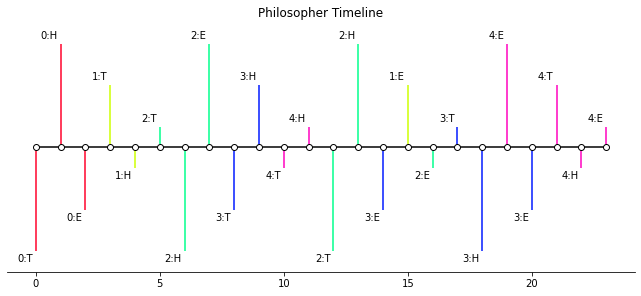

In [155]:
visualize(EVENTS.queue)